#  Analysis after Depth calling 
对于146个平均高表达的herv做site-wise的分析

In [3]:
import pandas as pd
from matplotlib_venn import venn2,venn3,venn3_unweighted
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from itertools import repeat
import pickle
import time
from pandarallel import pandarallel

In [10]:
site_wise_exp_df = pd.read_csv('data/34paired_COAD_herv_level_statistic.csv')
site_wise_exp_df['herv'] = site_wise_exp_df['herv'].apply(lambda x:x.split('_')[0])
print(site_wise_exp_df.shape)
site_wise_exp_df['pos'] -= 1 #index starts from 1.
site_wise_exp_df.head()

(368579, 7)


,herv,pos,avg_tumor,avg_normal,logFC,pvalue,threshold
0,4126,1933,0.029412,0.0,10.0,0.324587,Up
1,4126,1934,0.029412,0.0,10.0,0.324587,Up
2,4126,1935,0.029412,0.0,10.0,0.324587,Up
3,4126,1936,0.029412,0.0,10.0,0.324587,Up
4,4126,1937,0.029412,0.0,10.0,0.324587,Up


## 位点筛选details
1. 筛掉在uniport人蛋白pep的sites
2. 去掉avg_tumor==0的， 252382/864725 
1. pvalue筛选？  

In [5]:
# those avg_tumor != 0, summary avg_tumor
site_wise_exp_df[site_wise_exp_df['avg_tumor']!=0].describe()

,pos,avg_tumor,avg_normal,logFC,pvalue
count,120538.000000,120538.000000,120538.000000,120538.000000,120538.000000
mean,3038.510934,0.400899,0.073071,6.961895,0.325389
std,1985.309033,0.976406,0.455658,4.651097,0.292648
min,0.000000,0.029412,0.000000,-7.149747,-10.000000
25%,1380.000000,0.029412,0.000000,2.000000,0.183612
50%,2793.000000,0.058824,0.000000,10.000000,0.324587
75%,4522.000000,0.176471,0.029412,10.000000,0.324587
max,10825.000000,19.029412,13.764706,10.000000,1.000000


In [6]:
with open('data/exclude_position.pkl','rb') as f:
    exclude_position = pickle.load(f)

In [7]:
# drop sites from uniport
filtered_sites = pd.DataFrame()
for h_id in site_wise_exp_df['herv'].unique():
    a = site_wise_exp_df[(site_wise_exp_df['herv']==h_id)]
    filtered_sites = filtered_sites.append(a[~a['pos'].isin(exclude_position[int(h_id)])])


In [11]:
# no filter
filtered_sites = site_wise_exp_df

排除可能表达人蛋白的位点（剩下218124个）,其中tumor表达不为零的有68554个

In [12]:
filtered_sites.shape,filtered_sites[filtered_sites['avg_tumor']!=0].shape

((368579, 7), (120538, 7))

平均高表达的herv的每个位点的差异表达画火山图

/home/bio/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10


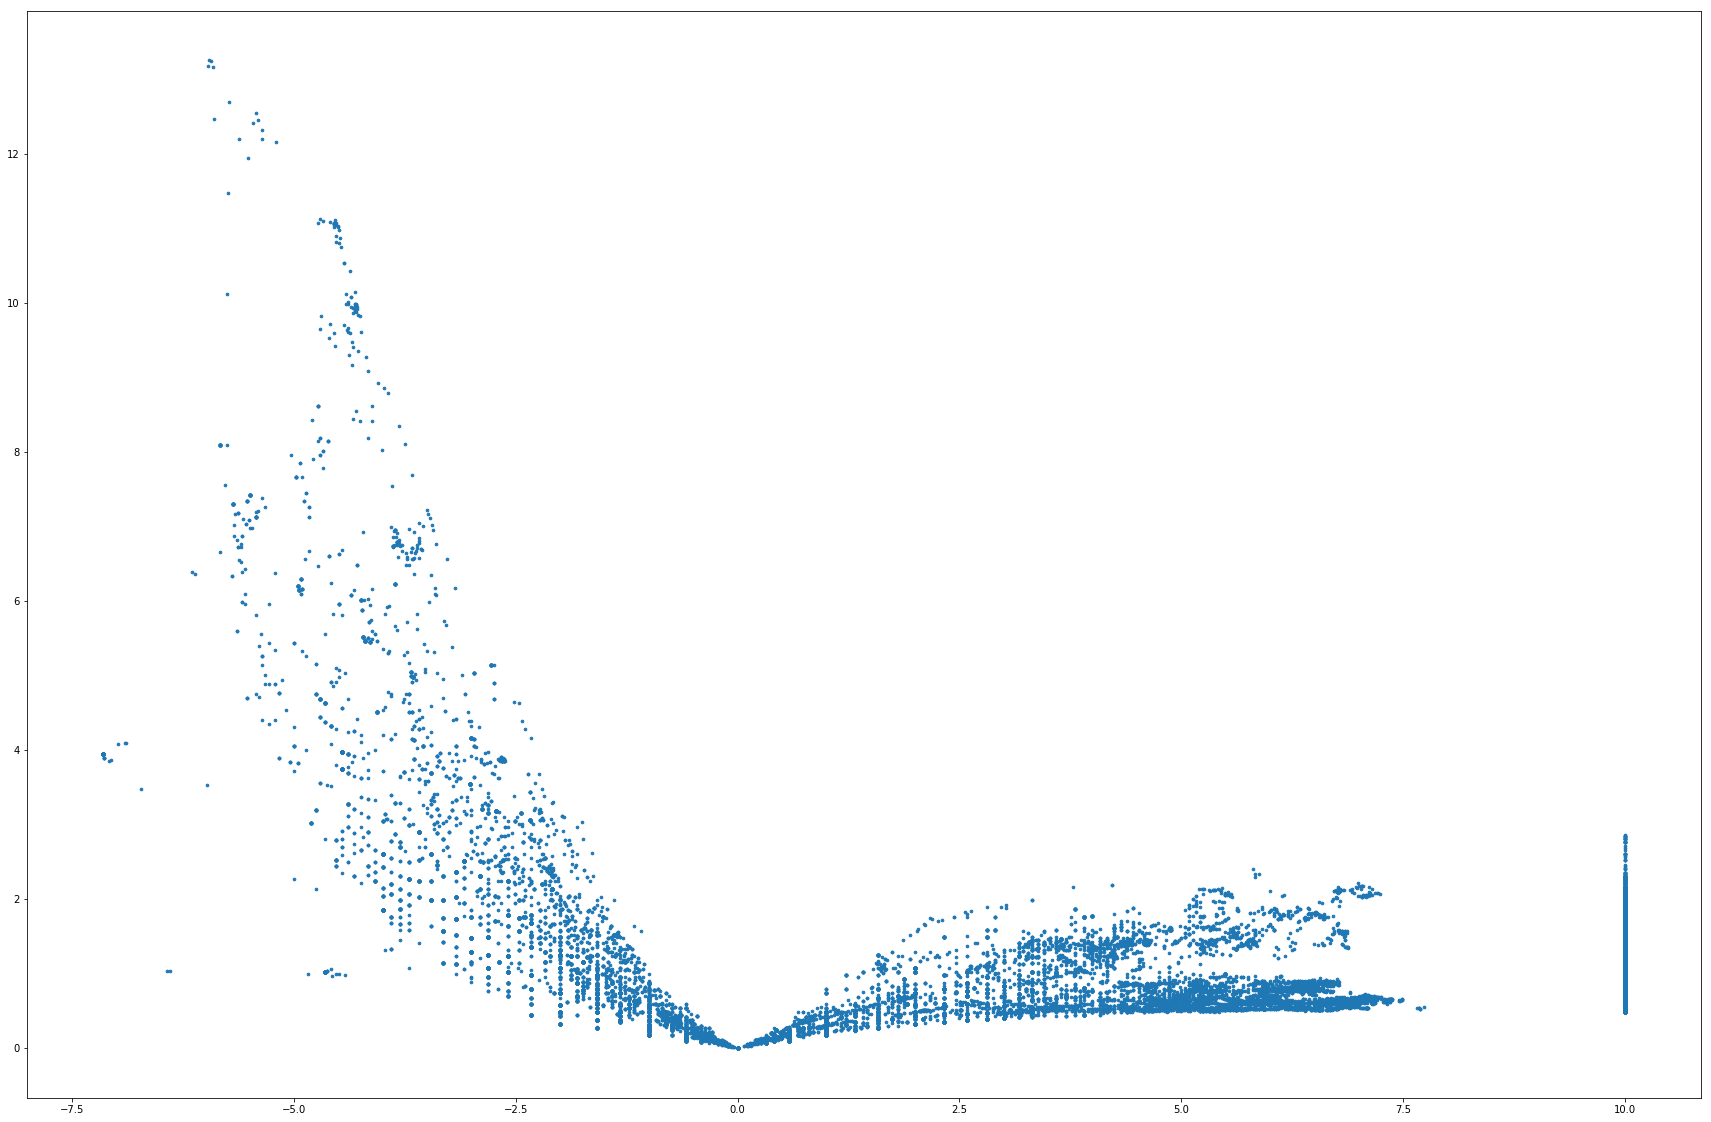

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

b = site_wise_exp_df[site_wise_exp_df['avg_tumor']!=0]
#b_01 = filtered_sites[(filtered_sites['avg_tumor']!=0)&(filtered_sites['logFC']>0)]
#b_01 = filtered_sites[(filtered_sites['avg_tumor']!=0)]

fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)

# plot dots
ax.scatter(b['logFC'],-1*np.log10(b['pvalue']),s=7,label='others') 
#ax.scatter(b_01['logFC'],-1*np.log10(b_01['pvalue']),s=1,label='not human',c='red')

## From sites to consecutive sequence

In [14]:
s_w_exp_filtered = filtered_sites[(filtered_sites['avg_tumor']>0)&(filtered_sites['logFC']>1)]

In [16]:
def consecutive(data, stepsize=1):
    data = s_w_exp_filtered.loc[data,:]['pos'].ravel() # convert to np.array
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

grouped = s_w_exp_filtered[['herv','pos']].groupby('herv')
consecutive_seqs = list(map(consecutive,grouped.groups.values()))

con_df = pd.DataFrame()
con_df['herv'] = grouped.groups.keys()
con_df['con_seqs'] = consecutive_seqs
con_df['index'] = range(len(con_df))

选择threshold,如thre，即比21bp长的seq我们才认为它有可能转录出candidate peptides。

In [17]:
thre = 21 # length threshold
con_df['con_k_seqs'] = con_df['con_seqs'].apply(lambda x:[a for a in x if len(a)>thre]) #

In [23]:
con_df

,herv,con_seqs,index,con_k_seqs
0,1090,"[[601, 602, 603, 604, 605, 606, 607, 608, 609,...",0,"[[601, 602, 603, 604, 605, 606, 607, 608, 609,..."
1,1180,"[[419, 420, 421, 422, 423, 424, 425, 426, 427,...",1,"[[419, 420, 421, 422, 423, 424, 425, 426, 427,..."
2,1229,"[[375, 376, 377, 378, 379, 380, 381, 382, 383,...",2,"[[375, 376, 377, 378, 379, 380, 381, 382, 383,..."
3,1230,"[[197, 198, 199, 200, 201, 202, 203, 204, 205,...",3,"[[197, 198, 199, 200, 201, 202, 203, 204, 205,..."
4,1256,"[[657, 658, 659, 660, 661, 662, 663, 664, 665,...",4,"[[657, 658, 659, 660, 661, 662, 663, 664, 665,..."
5,1493,"[[377, 378, 379, 380, 381, 382, 383, 384, 385,...",5,"[[377, 378, 379, 380, 381, 382, 383, 384, 385,..."
6,1624,"[[1524, 1525, 1526, 1527, 1528, 1529, 1530, 15...",6,"[[1524, 1525, 1526, 1527, 1528, 1529, 1530, 15..."
7,1692,"[[60, 61, 62, 63], [112, 113, 114, 115, 116, 1...",7,"[[112, 113, 114, 115, 116, 117, 118, 119, 120,..."
8,1757,"[[1873, 1874, 1875, 1876, 1877, 1878, 1879, 18...",8,"[[1873, 1874, 1875, 1876, 1877, 1878, 1879, 18..."
9,1926,"[[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, ...",9,"[[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, ..."


In [20]:
con_df.shape

(65, 4)

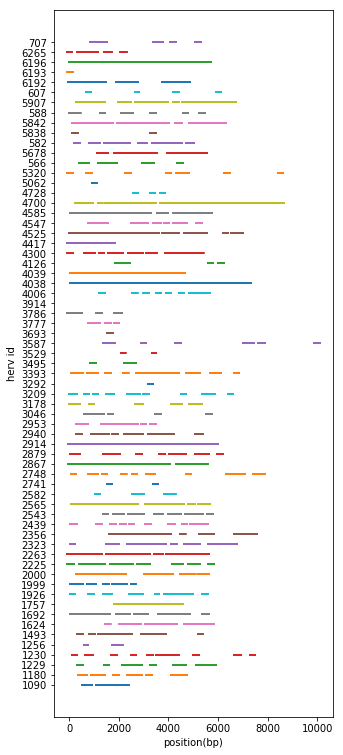

In [29]:
def plot_consecutive_positions(row):
    x = []
    for s in row['con_k_seqs']:
        x+=list(s)
    plt.scatter(x,np.repeat(row['index'],len(x)),marker='_')

k = 65# plot k herv
plt.figure(figsize=(5,k/5))
con_df[:k].apply(plot_consecutive_positions,axis=1)
plt.yticks(con_df[:k]['index'],con_df[:k]['herv'])
plt.ylabel('herv id')
plt.xlabel('position(bp)')
plt.show()

将每一段存入df

In [30]:
# significantly differenct expression sequences 
con_pos_list = []
con_df.loc[con_df['con_k_seqs'].apply(len)>0,:].apply(lambda row:[con_pos_list.append((row.herv,x[0],x[-1])) for x in row.con_k_seqs ],axis=1)
a = list(zip(*con_pos_list))
diff_exp_seqs=pd.DataFrame()
diff_exp_seqs['herv_id'] = a[0]
diff_exp_seqs['start_pos'] = a[1]
diff_exp_seqs['end_pos'] = a[2]
diff_exp_seqs

,herv_id,start_pos,end_pos
0,1090,601,648
1,1090,810,848
2,1090,1149,1196
3,1090,1245,1320
4,1090,1461,1508
5,1090,1528,1575
6,1090,1716,1750
7,1090,1920,1995
8,1090,2045,2092
9,1090,2108,2181


## slide window 切上面的片段

In [31]:
from Bio import Entrez,SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import single_letter_alphabet,generic_dna

In [32]:
ref_path = '/data/Yyyx_data/data_backup/data/TCGA_data/hervquant_final_reference.fa'
ref = SeqIO.to_dict(SeqIO.parse(ref_path, "fasta"))
ref_df = pd.DataFrame(ref.items(),columns=['herv_id','seq'])
ref_df['seq'] = ref_df['seq'].apply(lambda x:x.seq)
ref_df['herv_id'] = ref_df['herv_id'].apply(lambda x:x.split('_')[0])
ref_df.set_index(ref_df['herv_id'].astype(int),drop=True,inplace=True)
del ref 
ref_df = ref_df.loc[diff_exp_seqs.herv_id.unique().astype(int),:]
diff_exp_seqs['seq'] = ref_df.loc[diff_exp_seqs.herv_id.astype(int),:]['seq'].values
del ref_df
diff_exp_seqs['seq'] = diff_exp_seqs.apply(lambda row:row['seq'][row.start_pos:row.end_pos],axis=1)
diff_exp_seqs['seq_len'] = diff_exp_seqs['seq'].apply(len)
diff_exp_seqs

,herv_id,start_pos,end_pos,seq,seq_len
0,1090,601,648,"(A, T, T, T, G, G, A, A, G, C, A, C, A, A, A, ...",47
1,1090,810,848,"(C, C, C, C, T, G, A, T, G, T, A, T, A, T, C, ...",38
2,1090,1149,1196,"(A, T, G, A, T, T, A, A, C, A, G, A, T, A, A, ...",47
3,1090,1245,1320,"(T, G, G, G, C, A, C, A, T, A, G, C, T, C, C, ...",75
4,1090,1461,1508,"(C, T, T, A, G, C, T, G, A, G, C, A, A, G, A, ...",47
5,1090,1528,1575,"(A, A, G, T, A, T, T, T, T, C, A, T, T, G, T, ...",47
6,1090,1716,1750,"(C, A, C, A, C, A, G, T, T, A, A, T, T, G, A, ...",34
7,1090,1920,1995,"(T, A, G, A, C, A, C, T, T, T, C, A, C, A, A, ...",75
8,1090,2045,2092,"(C, T, T, T, T, A, C, A, G, G, A, G, G, A, G, ...",47
9,1090,2108,2181,"(C, A, C, A, T, A, T, T, C, T, C, T, C, A, T, ...",73


In [33]:
def slide_window_translate(mrna,peptide_window_min_length=7,
                           peptide_window_max_length=15,min_len=7):
    '''function: translate mRNA into every possible protein with length between  
                 peptide window min to max length ;stop translate when meet Terminator        
      input: 
          mrna: a Bio.Seq mRNA object
          peptide_window_min_length: min length of peptide you want(aa)
          peptide_window_max_length: max length
          min_len: threshold(>=) filtering short peptide when meet terminator
      return:
          every possible peptides between (window_min_len, max length)
          a list of peptide, mRNA start position(bp)
    '''
    l_min = peptide_window_min_length*3
    l_max = peptide_window_max_length*3
    l_list = [i for i in range(l_min,min(len(mrna)+1,l_max+1),3)]
    
    pep_list = []
    index_list = []
    for l in l_list:
        for i in range(0,len(mrna)-l):
            p = mrna[i:i+l].translate(to_stop=True)
            if len(p) >= min_len:
                pep_list.append(p)
                index_list.append(i)
    return pep_list,index_list

In [34]:
p_list = []
id_l = []
index_l = []
direction = []
for id,h in diff_exp_seqs.iterrows():
    pp_f,ind_l_f = slide_window_translate(h['seq'])# 
    pp_r,ind_l_r = slide_window_translate(h['seq'].reverse_complement())
    p_list += pp_f
    direction += list(np.repeat('f',len(pp_f)))
    id_l += list(np.repeat(h['herv_id'],len(pp_f)))
    index_l += [a+h['start_pos'] for a in ind_l_f]
    p_list += pp_r
    id_l += list(np.repeat(h['herv_id'],len(pp_r)))
    index_l += [a+h['start_pos'] for a in ind_l_r]
    direction += list(np.repeat('r',len(pp_r)))
    
pep_diff_exp  = pd.DataFrame()
pep_diff_exp['herv_id'] = id_l
pep_diff_exp['peptide'] = p_list
pep_diff_exp['position_index'] = index_l
pep_diff_exp['direction'] = direction

In [35]:
pep_diff_exp['peptide'].drop_duplicates().shape

/home/bio/miniconda3/lib/python3.6/site-packages/Bio/Seq.py:175: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


(351228,)

In [36]:
pep_diff_exp

,herv_id,peptide,position_index,direction
0,1090,"(F, G, S, T, N, K, Q)",602,f
1,1090,"(L, E, A, Q, I, N, K)",603,f
2,1090,"(G, S, T, N, K, Q, G)",605,f
3,1090,"(E, A, Q, I, N, K, A)",606,f
4,1090,"(S, T, N, K, Q, G, K)",608,f
5,1090,"(A, Q, I, N, K, A, K)",609,f
6,1090,"(T, N, K, Q, G, K, A)",611,f
7,1090,"(Q, I, N, K, A, K, L)",612,f
8,1090,"(N, K, Q, G, K, A, A)",614,f
9,1090,"(I, N, K, A, K, L, L)",615,f


## 每个pep配上差异表达的信息

每个位置差异表达的信息在site_wise_exp_df

In [37]:
pos_logfc = s_w_exp_filtered
def pep_avg_expr(row):
    herv_id = row['herv_id']
    pos_start = row['position_index']
    pep_l = len(row['peptide'])
    a = pos_logfc[(pos_logfc['herv']==herv_id)&(pos_logfc['pos']>=pos_start) \
              & (pos_logfc['pos']<pos_start+pep_l)]
    logfc = a.logFC.mean()
    avg_t = a.avg_tumor.mean()
    avg_n = a.avg_normal.mean()
    p_value = a.pvalue.mean()
    return (logfc,avg_t,avg_n,p_value)

In [38]:
from ipywidgets import widgets
pandarallel.initialize(shm_size_mb = 1024*20, nb_workers=8,progress_bar=False)

start = time.process_time()
logfc,avg_t,avg_n,p_v = list(zip(*pep_diff_exp.parallel_apply(pep_avg_expr,axis=1)))

pep_diff_exp['avg_logFC'] = logfc
pep_diff_exp['avg_tumor_expr'] = avg_t
pep_diff_exp['avg_normal_expr'] = avg_n
pep_diff_exp['pvalue'] = p_v
print(time.process_time() - start)

New pandarallel memory created - Size: 20480 MB
Pandarallel will run on 8 workers
12.938742151


In [39]:
pep_diff_exp.head()

,herv_id,peptide,position_index,direction,avg_logFC,avg_tumor_expr,avg_normal_expr,pvalue
0,1090,"(F, G, S, T, N, K, Q)",602,f,10.0,0.029412,0.0,0.324587
1,1090,"(L, E, A, Q, I, N, K)",603,f,10.0,0.029412,0.0,0.324587
2,1090,"(G, S, T, N, K, Q, G)",605,f,10.0,0.029412,0.0,0.324587
3,1090,"(E, A, Q, I, N, K, A)",606,f,10.0,0.029412,0.0,0.324587
4,1090,"(S, T, N, K, Q, G, K)",608,f,10.0,0.029412,0.0,0.324587


In [40]:
import os
os.getcwd()
pep_diff_exp.to_csv('data/diffexpr_peptide_from_66hervs_nofilter.csv',index=0)

In [ ]:
plt.hist(avg_t,bins=[0,0.5,1,1.5,2,2.5,3,6.1],rwidth=0.7, alpha=0.7,label='tumor')
plt.hist(avg_n,bins=[0,0.5,1,1.5,2,2.5,3,6.1],rwidth=0.7, alpha=0.7,label='normal')
plt.legend()

(0, 0.5)

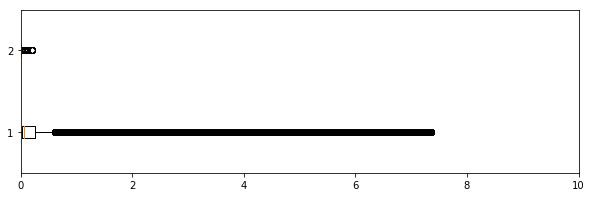

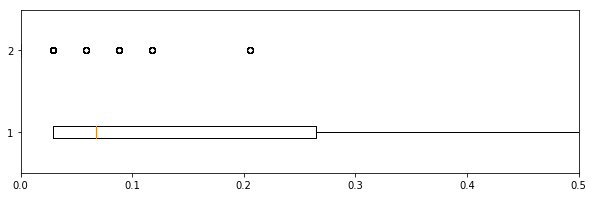

In [33]:
import seaborn as sns
plt.figure(figsize=(10,3))
plt.boxplot([avg_t,avg_n],positions=[1,2],vert=False)
plt.xlim([0,10])

plt.figure(figsize=(10,3))
plt.boxplot([avg_t,avg_n],positions=[1,2],vert=False)
plt.xlim([0,0.5])

## 和iedb对比

In [34]:
data = pd.read_csv("data/mhc_ligand_full.csv", usecols=[11,39,44,45],skiprows=[0],low_memory=False)

In [35]:
data_human = data[(data['Name'] == 'human (Homo sapiens)') | (data['Name'] == 'Homo sapiens')]
iedb_all_pep = data_human.loc[:,['Description']]

/home/bio/miniconda3/lib/python3.6/site-packages/Bio/Seq.py:175: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


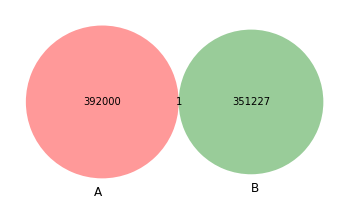

In [36]:
venn2(subsets=[set(iedb_all_pep['Description']),set(pep_diff_exp['peptide'])])